## Customer Service Agent for Clothing Retailer

### Custom AI Agent with Logging and Session Memory

The goal of this project is to create an AI agent for a clothing retailer. The agent will suggest items that match the style of the user's past purchases. Given a request to find an item the agent will search through the product database to find an apprpriate item. It wil prioritize items that are similar to those previously purchased by the user, and cross reference these to make sure the purchased items were not returned. It will look up returns and past purchases.

The agent's functionality also includes logging and session memory.

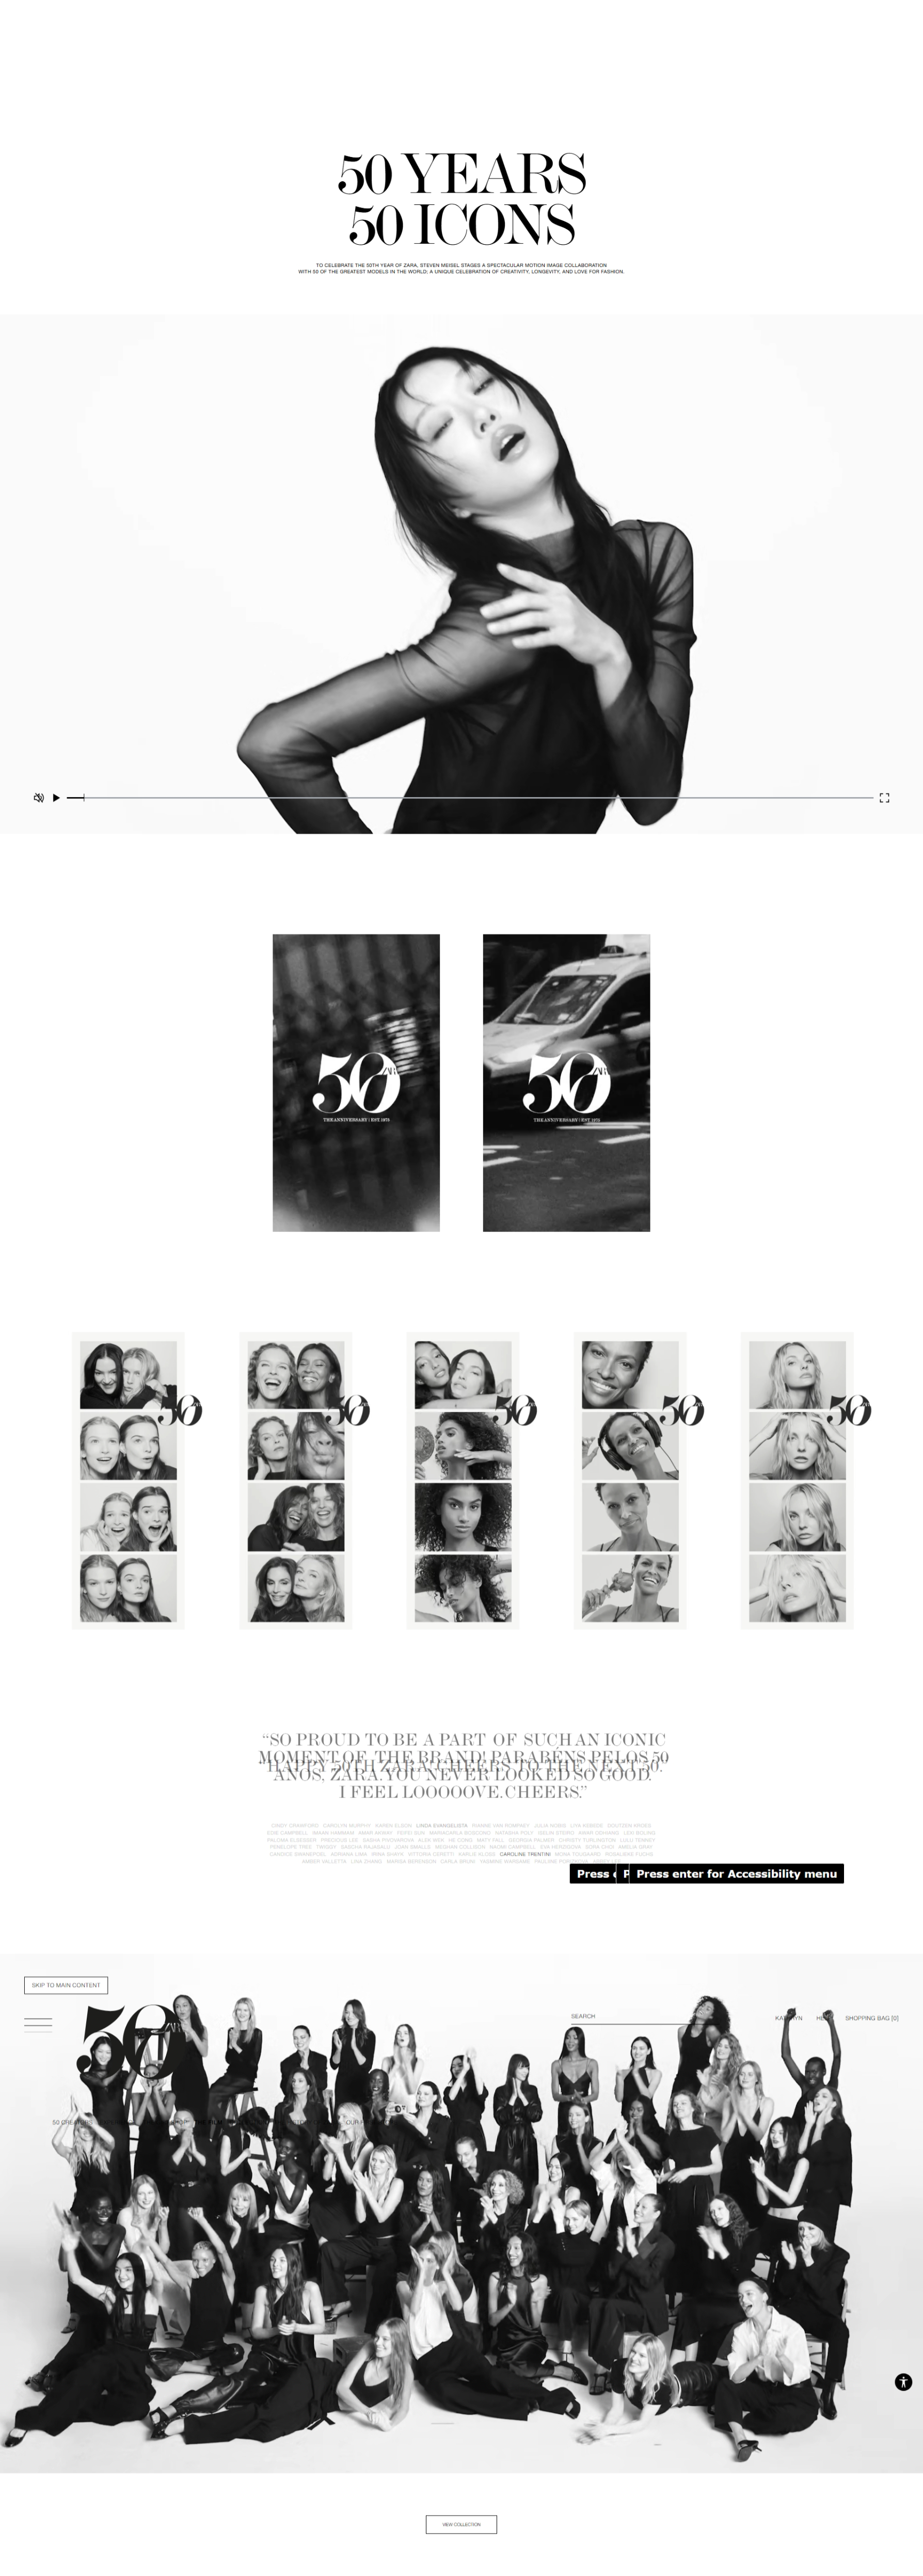

### Authenticate API key:

In [45]:
import os

from dotenv import load_dotenv

load_dotenv()

try:
    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    if not GOOGLE_API_KEY:
        raise ValueError("GOOGLE_API_KEY not found in .env file")


    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: Please check your .env file. Details: {e}")


✅ Gemini API key setup complete.


### Import ADK components

In [98]:
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService
from google.adk.memory import InMemoryMemoryService
from google.adk.tools import load_memory, preload_memory
from google.adk.runners import Runner
from google.adk.tools import google_search, AgentTool, ToolContext
from google.adk.code_executors import BuiltInCodeExecutor


from google.adk.plugins.logging_plugin import LoggingPlugin



print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


#### Define Retry Configurations for LLM calls

In [64]:
retry_config = types.HttpRetryOptions(
    attempts=5,  
    exp_base=7,  
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  
)

## Custom Tools

We will define custom tools to be used by our customer service agent. 1. Purchase History, 2. Customer Returns, 3. Item Recommendations


#### 1. Tool to fetch user's purchase history

#### Purchase history database
First we define a purchase_history_database to be used for testing. This is a list of dictionaries which include the userid, item purchased and the item's UPC.

In [ ]:
purchase_history_database = { "abigail454": {
        "red dress": "UI843972429",
        "blue jeans": "UP20928392",
        "white sneakers": "SN938475610"
    },
        "nick123": {
        "black leather jacket": "JL564738291",
        "gray hoodie": "HD837465920",
        "running shorts": "RS102938475"
    },
        "sophia789": {
        "floral skirt": "FS192837465",
        "denim jacket": "DJ564738920",
        "ankle boots": "AB837465192"
    }
       }


In [53]:

# Find Customer's purchase history using customer id as input

def get_purchase_history(user_id: str) -> dict:
    """
    Looks up the customer's purchase history

    Args:
        user_id (str): The customer's userid {"userid"}

    Returns:
        dict:
            Success -> {"status": "success", "purchase_history": {"item": "UPC"}}
            Error   -> {"status": "error", "error_message": "Customer history not found"}
    """

    # Lookup
    purchase_history = purchase_history_database.get(user_id)

    if purchase_history is not None:
        return {"status": "success", "purchase_history": purchase_history}
    else:
        return {
            "status": "error",
            "error_message": "No such customer found"
        }


# ✅ Test the tool
print("✅ Customer purchase history tool created")
print(f"💳 Test (abigail454): {get_purchase_history('abigail454')}")
print(f"💳 Test (nick123): {get_purchase_history('nick123')}")
print(f"💳 Test (sophia789): {get_purchase_history('sophia789')}")
print(f"💳 Test (unknown_user): {get_purchase_history('unknown_user')}")



✅ Customer purchase history tool created
💳 Test (abigail454): {'status': 'success', 'purchase_history': {'red dress': 'UI843972429', 'blue jeans': 'UP20928392', 'white sneakers': 'SN938475610'}}
💳 Test (nick123): {'status': 'success', 'purchase_history': {'black leather jacket': 'JL564738291', 'gray hoodie': 'HD837465920', 'running shorts': 'RS102938475'}}
💳 Test (sophia789): {'status': 'success', 'purchase_history': {'floral skirt': 'FS192837465', 'denim jacket': 'DJ564738920', 'ankle boots': 'AB837465192'}}
💳 Test (unknown_user): {'status': 'error', 'error_message': 'No such customer found'}


### 2. Tool that fetches the user's returns

First we define a customer returns database to be used for testing. This is a list of dictionaries which each include customer id, item description and item UPC for each item returned by the customer.

In [54]:
# Customer returns database
customer_returns_database = {
        "abigail454": {
            "blue jeans": "UP20928392"   # Returned item
        },
        "nick123": {
            # No returns yet
        },
        "sophia789": {
            # No returns yet
        }
    }

In [55]:
# Find items returned by the customer

def get_customer_returns(user_id: str) -> dict:
    """
    Looks up the customer's returns

    Args:
        user_id (str): The customer's userid {"userid"}

    Returns:
        dict:
            Success -> {"status": "success", "customer_returns": {"item": "UPC"}}
            Error   -> {"status": "error", "error_message": "Customer not found"}
    """

    
 # Lookup
    customer_returns = customer_returns_database.get(user_id)

    if customer_returns is not None:
        return {"status": "success", "customer_returns": customer_returns}
    else:
        return {
            "status": "error",
            "error_message": "No such customer found"
        }


# ✅ Test the tool
print("✅ Customer returns lookup tool created")
print(f"💳 Test (abigail454): {get_customer_returns('abigail454')}")
print(f"💳 Test (nick123): {get_customer_returns('nick123')}")
print(f"💳 Test (sophia789): {get_customer_returns('sophia789')}")
print(f"💳 Test (unknown_user): {get_customer_returns('unknown_user')}")


✅ Customer returns lookup tool created
💳 Test (abigail454): {'status': 'success', 'customer_returns': {'blue jeans': 'UP20928392'}}
💳 Test (nick123): {'status': 'success', 'customer_returns': {}}
💳 Test (sophia789): {'status': 'success', 'customer_returns': {}}
💳 Test (unknown_user): {'status': 'error', 'error_message': 'No such customer found'}


### 3. Item Reommendations Tool

#### Product Database 
Here we define a product_database to be used for testing. This contains item descriptions and their associated UPC numbers. 

In [56]:

# A sample product database for testing. This includes item description and a UPC number to identify each item, including its size and colour.
product_database = {
    "red dress": {
        "black dress": "BD837465920",
        "summer dress": "SD564738291",
        "cocktail dress": "CD102938475"
    },
    "blue jeans": {
        "denim jacket": "DJ564738920",
        "skinny jeans": "SJ837465192",
        "cargo pants": "CP192837465"
    },
    "white sneakers": {
        "running shoes": "RS938475610",
        "canvas sneakers": "CS564738920",
        "slip-ons": "SO837465192"
    },
    "black leather jacket": {
        "bomber jacket": "BJ564738291",
        "motorcycle jacket": "MJ837465920",
        "trench coat": "TC102938475"
    },
    "gray hoodie": {
        "zip hoodie": "ZH564738920",
        "pullover hoodie": "PH837465192",
        "sweatshirt": "SW192837465"
    },
    "running shorts": {
        "track pants": "TP564738291",
        "gym shorts": "GS837465920",
        "compression leggings": "CL102938475"
    },
    "floral skirt": {
        "pleated skirt": "PS564738920",
        "mini skirt": "MS837465192",
        "maxi skirt": "MX192837465"
    },
    "denim jacket": {
        "leather jacket": "LJ564738291",
        "windbreaker": "WB837465920",
        "parka": "PK102938475"
    },
    "ankle boots": {
        "chelsea boots": "CB564738920",
        "combat boots": "CO837465192",
        "loafers": "LF192837465"
    }
}


#### Product Style database. 
This database lists items in categories. This is a list of lists. Each list would be a group of items that have at least two similar attributes, e.g. style, colour, item type.

In [57]:
product_style_database = [["red dress", "black dress", "summer dress", "cocktail dress"],
                          ["black leather jacket", "bomber jacket", "motorcycle jacket"],
                        ]


### Item Recommendation Tool Creation

The following tool creates item suggestions based on the user's past purchases, with any returned items removed. It compares items by checking the product_style_database. If an item comes up twice in two different groups, we will only add it once to the list of suggested items.

In [58]:
def get_item_recommendation(user_id: str) -> dict:
    """
    Suggests clothing items (with UPCs) similar to those previously purchased,
    excluding items the customer has returned. Uses product_style_database groups.
    """
    purchase_history = purchase_history_database.get(user_id)
    returns = customer_returns_database.get(user_id)

    if purchase_history is None:
        return {"status": "error", "error_message": "No such customer found"}

    suggested_items = {}

    for item in purchase_history.keys():
        # Skip items the customer has returned
        if returns and item in returns:
            continue

        # Find the style group containing this item
        for group in product_style_database:
            if item in group:
                # Suggest other items in the same group
                for similar_item in group:
                    if similar_item != item:  # don't suggest the exact same item
                        if similar_item not in suggested_items:
                            suggested_items[similar_item] = product_database.get(similar_item)


    suggested_items = list(suggested_items.items())
    

    return {"status": "success", "suggested_items": suggested_items}


# ✅ Test the tool
print("✅ Product recommendation tool created")
print(f" Test (abigail454): {suggest_similar_items('abigail454')}")
print(f" Test (nick123): {suggest_similar_items('nick123')}")
print(f" Test (sophia789): {suggest_similar_items('sophia789')}")
print(f" Test (unknown_user): {suggest_similar_items('unknown_user')}")



✅ Product recommendation tool created
 Test (abigail454): {'status': 'success', 'suggested_items': [('black dress', None), ('summer dress', None), ('cocktail dress', None)]}
 Test (nick123): {'status': 'success', 'suggested_items': [('bomber jacket', None), ('motorcycle jacket', None)]}
 Test (sophia789): {'status': 'success', 'suggested_items': []}
 Test (unknown_user): {'status': 'error', 'error_message': 'No such customer found'}


#### Helper Function

Here we add a helper function that prints the generated Python code and results from the code execution tool:

In [60]:
def show_python_code_and_result(response):
    for i in range(len(response)):
        # Check if the response contains a valid function call result from the code executor
        if (
            (response[i].content.parts)
            and (response[i].content.parts[0])
            and (response[i].content.parts[0].function_response)
            and (response[i].content.parts[0].function_response.response)
        ):
            response_code = response[i].content.parts[0].function_response.response
            if "result" in response_code and response_code["result"] != "```":
                if "tool_code" in response_code["result"]:
                    print(
                        "Generated Python Code >> ",
                        response_code["result"].replace("tool_code", ""),
                    )
                else:
                    print("Generated Python Response >> ", response_code["result"])


print("✅ Helper functions defined.")

✅ Helper functions defined.


### Cutomer Service Agent

Here we will define the customer AI agent for shopping recommendations, fetching user purchase history and returns.

In [118]:
# Here we have added ADK's built-in Memory Service for development and testing

memory_service = (InMemoryMemoryService())  

# Create Session Service
session_service = InMemorySessionService()  # Handles conversations


print("✅ Agent and Runner created with memory support!")

✅ Agent and Runner created with memory support!


Create auto-callback, so that we can save each session to memory

In [119]:
async def auto_save_to_memory(callback_context):
    """Automatically save session to memory after each agent turn."""
    await callback_context._invocation_context.memory_service.add_session_to_memory(
        callback_context._invocation_context.session
    )


print("✅ Callback created.")

✅ Callback created.


In [ ]:

# Customer Service agent for fashion retailer with custom function tools
customer_service_agent = LlmAgent(
    name="customer_agent",
    model=Gemini(model="gemini-2.5-flash-lite", 
                 retry_options=retry_config),
    instruction="""You are a smart customer service assistant for a fashion retailer. You respond in a friendly and enthusiastic manner. You are always polite.

    If a customer asks for item recommendations use:
    2. get_purchase_history() to see what they have purchased in the past
    3. get_customer_returns() to check that the items you find have not been returned by the customer 
    3. get_item_recommendation() to find items simlar to what they have liked in the past

    If any tool returns status "error", explain the issue to the user clearly.
    """,
    tools=[get_item_recommendation, get_purchase_history, get_customer_returns, preload_memory],
    # Save memory after each turn

    after_agent_callback=auto_save_to_memory    
    
)

print("✅ Customer service agent created with product recommendation tools")
print("🔧 Available tools:")
print("  • get_suggestion - Looks up items the custome might be interested in")
print("  • get_returns - Looks up items the customer has returned")

✅ Customer service agent created with product recommendation tools
🔧 Available tools:
  • get_suggestion - Looks up items the custome might be interested in
  • get_returns - Looks up items the customer has returned


#### Customer Service Agent Runner with Logging Plugin

Here we create the runner with logging. We test the runner with user input "My user id is abigail454 please recommend some items for me to purchase."

In [122]:

from google.genai import types
import asyncio

APP_NAME = "memory_app"

async def main():
    # Configure the runner
    runner = Runner(
        agent=customer_service_agent,
        app_name = APP_NAME,
        plugins=[LoggingPlugin()],   # Observability logging
        session_service=session_service,
        memory_service=memory_service
    )

    # Run a debug prompt
    result = await runner.run_debug(
        "My user id is abigail454 please recommend some items for me to purchase."
    )

print("✅ Runner configured")
print("🔎 Debug result:", result)

result = await main()






✅ Runner configured
🔎 Debug result: [Event(model_version='gemini-2.5-flash-lite', content=Content(
  parts=[
    Part(
      text="I'd love to help you find some new additions to your wardrobe, abigail454! To give you the best recommendations, I'll need to take a peek at your past purchases and see what you've loved."
    ),
    Part(
      function_call=FunctionCall(
        args={
          'user_id': 'abigail454'
        },
        id='adk-14725447-59ce-40c6-ac4b-869fa56b7d9b',
        name='get_purchase_history'
      )
    ),
    Part(
      function_call=FunctionCall(
        args={
          'user_id': 'abigail454'
        },
        id='adk-900a6f9f-713f-41b3-b8e7-ccefea4c4e1c',
        name='get_customer_returns'
      )
    ),
  ],
  role='model'
), grounding_metadata=None, partial=None, turn_complete=None, finish_reason=<FinishReason.STOP: 'STOP'>, error_code=None, error_message=None, interrupted=None, custom_metadata=None, usage_metadata=GenerateContentResponseUsageMetadata

[logging_plugin] 🧠 LLM RESPONSE
[logging_plugin]    Agent: customer_agent
[logging_plugin]    Content: text: 'Sure, I can help with that! I'll just need to look up your purchase history and returns to make the best recommendations for you. One moment!' | function_call: get_purchase_history | function_call: get_customer_returns
[logging_plugin]    Token Usage - Input: 477, Output: 79
[logging_plugin] 📢 EVENT YIELDED
[logging_plugin]    Event ID: 30d3b6af-2c2d-4473-91d4-1222b470242f
[logging_plugin]    Author: customer_agent
[logging_plugin]    Content: text: 'Sure, I can help with that! I'll just need to look up your purchase history and returns to make the best recommendations for you. One moment!' | function_call: get_purchase_history | function_call: get_customer_returns
[logging_plugin]    Final Response: False
[logging_plugin]    Function Calls: ['get_purchase_history', 'get_customer_returns']
customer_agent > Sure, I can help with that! I'll just need to look up your purchase hist

[logging_plugin] 🧠 LLM RESPONSE
[logging_plugin]    Agent: customer_agent
[logging_plugin]    Content: function_call: get_item_recommendation
[logging_plugin]    Token Usage - Input: 660, Output: 24
[logging_plugin] 📢 EVENT YIELDED
[logging_plugin]    Event ID: 073b7148-6901-4cfd-8b36-a54674a5280c
[logging_plugin]    Author: customer_agent
[logging_plugin]    Content: function_call: get_item_recommendation
[logging_plugin]    Final Response: False
[logging_plugin]    Function Calls: ['get_item_recommendation']
[logging_plugin] 🔧 TOOL STARTING
[logging_plugin]    Tool Name: get_item_recommendation
[logging_plugin]    Agent: customer_agent
[logging_plugin]    Function Call ID: adk-39b9698e-2d28-40e2-af61-9d35d97149f5
[logging_plugin]    Arguments: {'user_id': 'abigail454'}
[logging_plugin] 🔧 TOOL COMPLETED
[logging_plugin]    Tool Name: get_item_recommendation
[logging_plugin]    Agent: customer_agent
[logging_plugin]    Function Call ID: adk-39b9698e-2d28-40e2-af61-9d35d97149f5
[logging